In [1]:
from sklearn.datasets import load_files
import numpy as np
import keras.utils as np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Activation, Conv2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, rmsprop, SGD
from tqdm import tqdm
import pandas as pd
from keras.callbacks import ModelCheckpoint
import os
from keras.utils import to_categorical
from keras.models import Model, Sequential
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import h5py
%matplotlib inline
plt.style.use("fivethirtyeight")

Using TensorFlow backend.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Implicit localization with GAPs

So this is quite irrelevant to the rest of the notebook, but I  just read this interesting [paper](https://arxiv.org/abs/1512.04150v1) on an intersting property of CNNs, namely their ability to, with some help from some special layers, implicitly localize the object of interest in a particular image using something called the Global Average Pooling Layer (GAP).

In [117]:
files = os.listdir("data/cifar10/train/")

# sample 5000 images to train with
sampled_files = np.random.choice(files, 50000, replace=False)
labels = pd.read_csv("data/cifar10/trainLabels.csv").set_index("id")

dataset_labels = [labels.loc[int(s.split('.')[0])].label for s in sampled_files]

assert len(set(dataset_labels))==10

In [118]:
le = LabelEncoder() # to convert string labels to integers 
y_train = to_categorical(le.fit_transform(dataset_labels), 10)

In [129]:
X_train = []
for f in tqdm(sampled_files):
    X_train.append(img_to_array(load_img("data/cifar10/train/"+f)))

X_train = np.array(X_train)/255

100%|██████████| 50000/50000 [00:29<00:00, 1679.18it/s]


In [136]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

# initiate RMSprop optimizer
opt = rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [ ]:
# Takes too long (on a regular machine) and performance is bad
checkpointer = ModelCheckpoint(filepath='models/cifar_10_simple_cnn.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss")

model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.125, callbacks=[checkpointer])

In [295]:
model = load_model("models/cifar_10_simple_cnn.h5")

In [158]:
# extract the weights for the softmax from the last layer
w, b = model.layers[-1].get_weights()

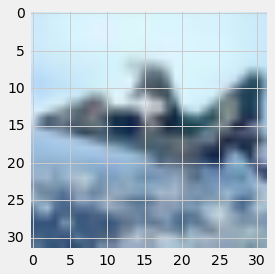

In [287]:
plt.imshow(X_train[0])

In [296]:
# let's look at class 0, airplane

# get airplane weights
auto_weights = w[:, 1]

# get activation map
act_map = Model(inputs=model.input, outputs=model.get_layer("max_pooling2d_12").output)

activation_maps = act_map.predict(np.array([X_train[0]]))[0]

In [297]:
cam = np.zeros([6,6])

for i in range(64):
    cam+=auto_weights[i] * activation_maps[:, :, i]

What the network pays attention to!

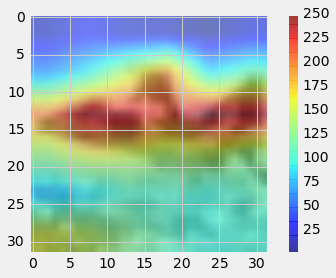

In [298]:
from scipy.misc import imresize
plt.imshow(X_train[0])
plt.imshow(imresize(cam, (32, 32)), alpha=0.5)
plt.colorbar()

Super cool! It seems like even a network that is not doing as well, can learn to localize important objects implicitly with the use of GAPs.

# Understanding Neural Nets.

This section will be dedicated to visualizing what is going on internally in the CNN!

First, let's use ```tensorflow``` to understand how a simple softmax classifier understands different mnist digits.

In [7]:
# Build the softmax classifier

# inputs to the model
x = tf.placeholder(dtype=tf.float32, shape=(None,784))
y = tf.placeholder(dtype=tf.float32, shape=(None,10)) # assume OHE data

W = tf.Variable(tf.truncated_normal(shape=(784, 10), stddev=0.1), tf.float32)
b = tf.Variable(tf.constant(0.1), tf.float32)

prob_distribution = tf.nn.softmax(tf.matmul(x, W) + b)

xent = -tf.reduce_mean(tf.reduce_sum(y*tf.log(prob_distribution), reduction_indices=[1])) # loss
optimizer =  tf.train.AdamOptimizer()

predictions = tf.argmax(prob_distribution, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, tf.argmax(y, 1)), tf.float32))

Very quick note here on the cross entropy loss. Essentially we are saying that the added loss will be $log(p_{t})$ where $p_t$ is the probability that our model gave to the correct class. Remember that y is an OHE vector so only that value above will be added to the error. Also remember that the cross entropy loss is nothing more than the negative log likelihood assuming our model follows a multinomial distribution (?).

In [8]:
# train the softmax
train_step = optimizer.minimize(xent)

batch_size = 50
n_steps = 2000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

for _ in range(n_steps):
    x_batch, y_batch = mnist.train.next_batch(batch_size=50)
    sess.run([train_step], feed_dict={x:x_batch, y:y_batch})
    
    if _ % 100==0:
        print("Train step: {0} - Acc.: {1} - Loss: {2}".format(_, sess.run([acc], feed_dict={x:x_batch, y:y_batch})[0], 
              sess.run([xent], feed_dict={x:x_batch, y:y_batch})[0]))

Train step: 0 - Acc.: 0.159999996424 - Loss: 2.52500677109
Train step: 100 - Acc.: 0.639999985695 - Loss: 1.10562026501
Train step: 200 - Acc.: 0.839999973774 - Loss: 0.654083311558
Train step: 300 - Acc.: 0.860000014305 - Loss: 0.486985385418
Train step: 400 - Acc.: 0.800000011921 - Loss: 0.587005019188
Train step: 500 - Acc.: 0.879999995232 - Loss: 0.451871603727
Train step: 600 - Acc.: 0.860000014305 - Loss: 0.48339137435
Train step: 700 - Acc.: 0.980000019073 - Loss: 0.264576256275
Train step: 800 - Acc.: 0.939999997616 - Loss: 0.263481467962
Train step: 900 - Acc.: 0.959999978542 - Loss: 0.254943966866
Train step: 1000 - Acc.: 0.899999976158 - Loss: 0.297028541565
Train step: 1100 - Acc.: 0.879999995232 - Loss: 0.351972222328
Train step: 1200 - Acc.: 0.899999976158 - Loss: 0.393375813961
Train step: 1300 - Acc.: 0.860000014305 - Loss: 0.37427341938
Train step: 1400 - Acc.: 0.939999997616 - Loss: 0.300139218569
Train step: 1500 - Acc.: 0.959999978542 - Loss: 0.247888043523
Train st

Weights for 0


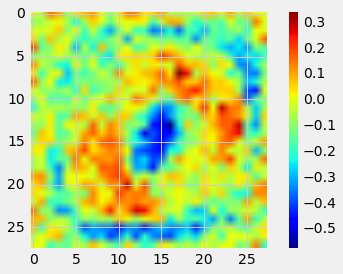

Weights for 1


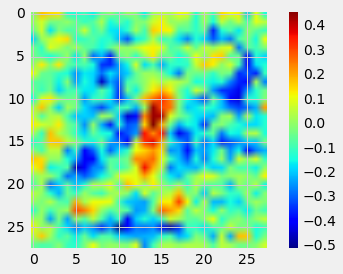

Weights for 2


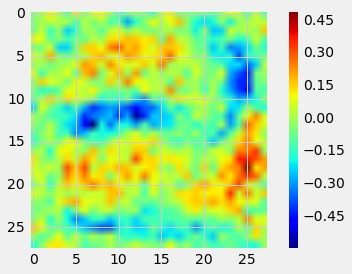

Weights for 3


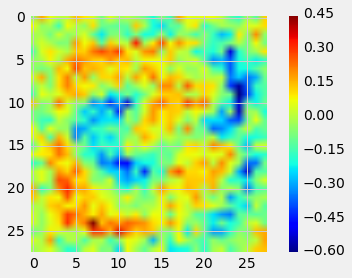

Weights for 4


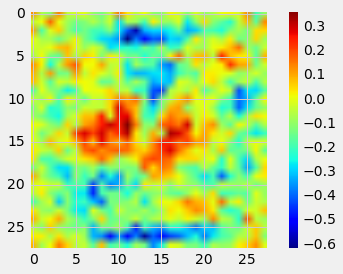

Weights for 5


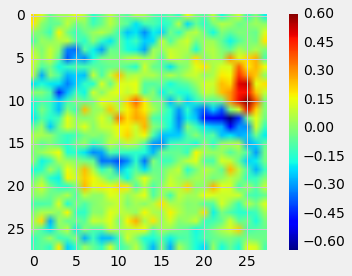

Weights for 6


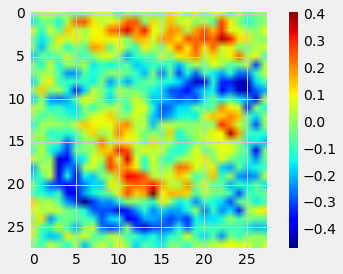

Weights for 7


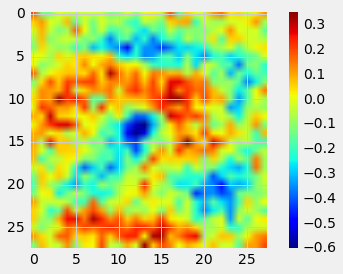

Weights for 8


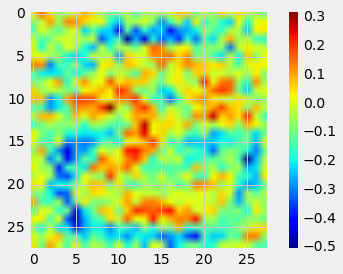

Weights for 9


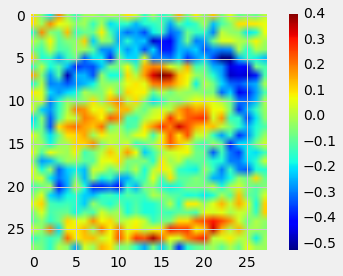

In [9]:
# Now let's visualize the weights learned for each digit
# A larger weight for a pixel represents an increased probability that a large value for that pixel will 
# mean the digit is that particular one as per the weight
w = sess.run(W)

for d in range(10):
    print("Weights for {}".format(d))
    img = w[:, d].reshape(28,28)
    plt.imshow(img)
    plt.colorbar()
    plt.show()

Notice that the softmax classifier is learning some shapes, however, you can tell that it will not really be robust if we slightly shift a particular digit. That is a reason people tend to perform set augmentations to make their classifiers more robust to this kind of problem.

# Visualizing the activations of a simple CNN on tensorflow

Following the excellent [article](https://www.jebruner.com/2017/07/interpreting-and-fooling-convolutional-neural-networks-part-2-with-code/) by Jon Bruner.

In [24]:
# urilities

tf.reset_default_graph()

def weight(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1, dtype=tf.float32), name=name)

def bias(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape, dtype=tf.float32), name=name)

def conv_2d(W, x, name):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME", name=name)

def max_pool(x, name, size=2):
    return tf.nn.max_pool(x, [1,size, size, 1], strides=[1,size, size, 1], padding='SAME', name=name)

In [25]:
# input placeholders

X = tf.placeholder(dtype=tf.float32, shape=[None, 784], name="input_image")
y = tf.placeholder(dtype=tf.float32, shape=[None, 10], name="true_label")

In [26]:
W_conv1 = weight([5, 5, 1, 32], 'W_conv1')
b_conv1 = bias([32], 'b_conv1')

# conv layer 1
img = tf.reshape(X, shape = (-1, 28, 28, 1), name='img')
W1 = weight([5, 5, 1, 32], "weight1")
b1 = bias([32], 'b_conv1')
conv1_ = conv_2d(W1, img, "conv1_")
conv1 = tf.nn.relu(conv1_ + b1, name="conv1")
max_pool1 = max_pool(conv1, "max_pool1")

# conv layer 2
W2 = weight([5, 5, 32, 64], "weight2")
b2 = bias([64], 'b_conv2')
conv2_ = conv_2d(W2, max_pool1, "conv2_")
conv2 = tf.nn.relu(conv2_ + b2, name="conv2")
max_pool2 = max_pool(conv2, "max_pool2")

# fc layers

# first fc layer
flatten = tf.reshape(max_pool2, [-1, 7*7*64], name='flatten')
W_fc1 = weight([7 * 7 * 64, 1024], 'W_fc1')
b_fc1 = weight([1024], 'b_fc1')
fc1 = tf.nn.relu(tf.matmul(flatten, W_fc1) + b_fc1, name='fc1')

# add some dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dropout = tf.nn.dropout(fc1, keep_prob=keep_prob, name='dropout')

# final layer
W_fc2 = weight([1024, 10], 'softmax_layer_weight')
b_fc2 = weight([10], 'softmax_layer_bias')
probs = tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2, name='final_layer')

# loss, accuracy, train_step etc
xent = tf.reduce_mean(-tf.reduce_sum(y*tf.log(probs + 1e-8), 1), name='cross_entropy') # xent might explode so take precutions
train_step = tf.train.AdamOptimizer().minimize(xent)
y_hat = tf.argmax(probs, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_hat, tf.argmax(y, 1)), tf.float32), name='accuracy')

In [28]:
# initialize and train
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run([init])

for i in tqdm(range(10000)):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_acc = sess.run(accuracy, feed_dict={X:batch[0], y: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_acc))
    sess.run(train_step, feed_dict={X: batch[0], y: batch[1], keep_prob: 0.5})

  0%|          | 1/10000 [00:00<44:51,  3.71it/s]

step 0, training accuracy 0.2


 10%|█         | 1001/10000 [03:02<27:19,  5.49it/s]

step 1000, training accuracy 0.98


 20%|██        | 2000/10000 [06:11<24:36,  5.42it/s]

step 2000, training accuracy 1


 30%|███       | 3000/10000 [09:30<28:01,  4.16it/s]

step 3000, training accuracy 1


 40%|████      | 4001/10000 [12:30<18:22,  5.44it/s]

step 4000, training accuracy 1


 50%|█████     | 5001/10000 [15:24<16:01,  5.20it/s]

step 5000, training accuracy 1


 60%|██████    | 6001/10000 [18:17<12:29,  5.33it/s]

step 6000, training accuracy 1


 70%|███████   | 7001/10000 [2:21:10<09:24,  5.31it/s]

step 7000, training accuracy 1


 80%|████████  | 8001/10000 [7:49:03<06:28,  5.14it/s]

step 8000, training accuracy 1


 90%|█████████ | 9001/10000 [7:52:02<03:07,  5.32it/s]

step 9000, training accuracy 1


100%|██████████| 10000/10000 [7:54:56<00:00,  5.56it/s]


In [29]:
print("test accuracy %g" % sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9914


In [30]:
# save the trained model
saver = tf.train.Saver()
save_path = saver.save(sess, "models/simple_mnist_cnn.ckpt")

In [116]:
# load saved session
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph('models/simple_mnist_cnn.ckpt.meta')
new_saver.restore(sess, 'models/simple_mnist_cnn.ckpt')

X = sess.graph.get_tensor_by_name("input_image:0")
y = sess.graph.get_tensor_by_name("true_label:0")
keep_prob = sess.graph.get_tensor_by_name("keep_prob:0")
accuracy = sess.graph.get_tensor_by_name("accuracy:0")

# Test, that should give 0.9914
print("test accuracy %g" % sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from models/simple_mnist_cnn.ckpt
test accuracy 0.9914


Now that we have our trained model, let's take a look at what each filter is learning.

In [225]:
# first select a test image
image = mnist.validation.images[1].reshape([1, 784]).copy()

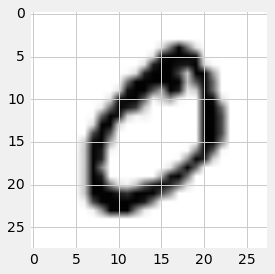

In [226]:
plt.imshow(image.reshape([28, 28]), cmap='Greys')

In [227]:
[W1] = sess.graph.get_operation_by_name("weight1").outputs
W1 = W1.eval()

[conv1] = sess.graph.get_operation_by_name("conv1").outputs
conv1 = conv1.eval(feed_dict={X:image})

[W2] = sess.graph.get_operation_by_name("weight2").outputs
W2 = W2.eval()

[conv2] = sess.graph.get_operation_by_name("conv2").outputs
conv2 = conv2.eval(feed_dict={X:image})

For each filter, print the filter and the activations for a particular image.

In [228]:
def vis_weights(image, layer=1, n_filters=5):
    
    if layer==1:
        sampled_feats = np.random.choice(W1.shape[-1], n_filters)
        
        filters = []
        activations = []
        most_activates = []
        
        [conv1] = sess.graph.get_operation_by_name("conv1").outputs
        
        for feature in range(W1.shape[-1]):
            
            # append the filter
            filters.append(W1[:, :, 0, feature])
            
            # append the activation
            [act] = sess.run([conv1[0, :, :, feature]], feed_dict={X:image})
            activations.append(act)
            
            # add picture that most activates the filter
            most_activates.append(most_activation_image(conv1, feature))
    else:
        sampled_feats = np.random.choice(W2.shape[-1], n_filters)
        filters = []
        activations = []
        most_activates = []
        
        [conv2] = sess.graph.get_operation_by_name("conv2").outputs
        
        for feature in range(W2.shape[-1]):
            
            # append the filter
            filters.append(W2[:, :, 0, feature])
            
            # append the activation
            [act] = sess.run([conv2[0, :, :, feature]], feed_dict={X:image})
            activations.append(act)
            
            # add picture that most activates the filter
            most_activates.append(most_activation_image(conv2, feature))
    
    return (filters, activations, most_activates), sampled_feats
        
def most_activation_image(layer, feature):
    image = np.random.uniform(0, 1, [1, 784])
    grad = tf.gradients(tf.reduce_mean(layer[0, :, :, feature]), X)

    for i in range(50):
        g = sess.run(grad, {X: image})
        g /= np.std(g) + 1e-8
        image += g[0]
    
    return image.reshape(28, 28)

def generate_plot(image, layer=1, n_filters=5):
    
    lst, filts = vis_weights(image, layer=1, n_filters=5)
    f, axarr= plt.subplots(3, n_filters, figsize=(20, 10))
    
    for i in range(3):
        for j in range(n_filters):
            axarr[i,j].imshow(lst[i][j], interpolation="none", cmap='Greys')
    
    axarr[0, 0].set_title("Layer: {0}, Filter: {1}".format(layer, filts[0]))
    axarr[0, 1].set_title("Layer: {0}, Filter: {1}".format(layer, filts[1]))
    axarr[0, 2].set_title("Layer: {0}, Filter: {1}".format(layer, filts[2]))
    axarr[0, 3].set_title("Layer: {0}, Filter: {1}".format(layer, filts[3]))
    axarr[0, 4].set_title("Layer: {0}, Filter: {1}".format(layer, filts[4]))
            
    return lst     

First row is the learned filter in the convolution
Second row is the result of the activation after the convolution (padding='SAME')
Third row is the image that most activates the filter


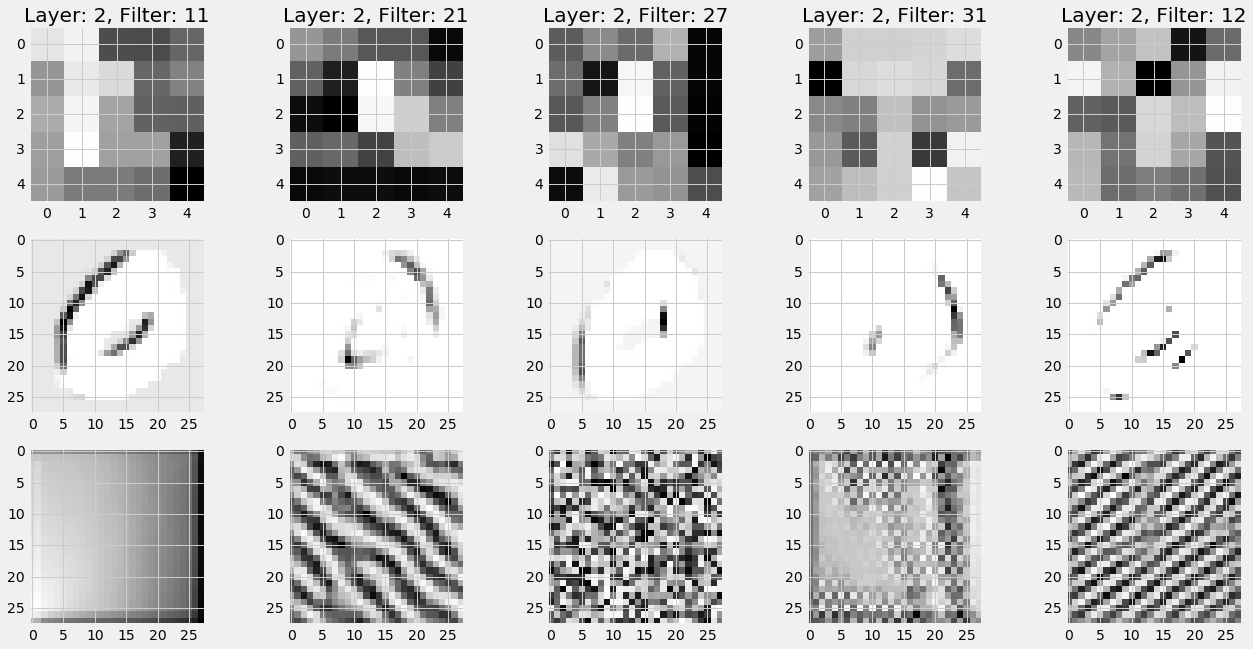

In [229]:
print("First row is the learned filter in the convolution")
print("Second row is the result of the activation after the convolution (padding='SAME')")
print("Third row is the image that most activates the filter")
lst = generate_plot(image, 2)

# Learning more advanced features with Keras

Now let's load one of the keras pretrained models and see what features the net sees at different depths!